# Density Estimation using Real NVP
## Paper: https://arxiv.org/pdf/1605.08803.pdf
## Code from: https://keras.io/examples/generative/real_nvp/

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

## Load the data

In [2]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.experimental.preprocessing.Normalization()
norm.adapt(data)
normalized_data = norm(data)

## Affine coupling layer

In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    # General input layer
    input = keras.layers.Input(shape=input_shape)

    # t network, takes in as input the input layer
    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    # s network, takes in as input the input layer
    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    # one model object to contain both t and s network, yet no sharing of layers
    # except input layer
    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

## Real NVP

In [4]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.n_dim = 2
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0]*self.n_dim, scale_diag=[1]*self.n_dim
        )
        # Hard coded mask for two dimensions 
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
        # Makes list of coupling networks with input size of 2
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0 # keeps track of log_det values
        
        direction = 1 # direction determines if foward or inverse
        if training:
            direction = -1
            
        for i in range(self.num_coupling_layers)[::direction]:
            # Flip mask each pass through couple layers
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            
            # Pass through couple layers, returns output of s and t network
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            
            # Apply exponential function 
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.
    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

## Model training

In [5]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(normalized_data, batch_size=256, 
                    epochs=300, verbose=2, validation_split=0.2)

Epoch 1/300
10/10 - 5s - loss: 2.7055 - val_loss: 2.5910
Epoch 2/300
10/10 - 0s - loss: 2.6041 - val_loss: 2.5403
Epoch 3/300
10/10 - 0s - loss: 2.5555 - val_loss: 2.4899
Epoch 4/300
10/10 - 0s - loss: 2.5165 - val_loss: 2.4604
Epoch 5/300
10/10 - 0s - loss: 2.4835 - val_loss: 2.4365
Epoch 6/300
10/10 - 0s - loss: 2.4557 - val_loss: 2.4114
Epoch 7/300
10/10 - 0s - loss: 2.4241 - val_loss: 2.3839
Epoch 8/300
10/10 - 0s - loss: 2.3936 - val_loss: 2.3628
Epoch 9/300
10/10 - 0s - loss: 2.3726 - val_loss: 2.3403
Epoch 10/300
10/10 - 0s - loss: 2.3472 - val_loss: 2.3179
Epoch 11/300
10/10 - 0s - loss: 2.3156 - val_loss: 2.3038
Epoch 12/300
10/10 - 0s - loss: 2.3072 - val_loss: 2.2673
Epoch 13/300
10/10 - 0s - loss: 2.2694 - val_loss: 2.2460
Epoch 14/300
10/10 - 0s - loss: 2.2485 - val_loss: 2.2204
Epoch 15/300
10/10 - 0s - loss: 2.2076 - val_loss: 2.1948
Epoch 16/300
10/10 - 0s - loss: 2.1827 - val_loss: 2.1821
Epoch 17/300
10/10 - 0s - loss: 2.1630 - val_loss: 2.1749
Epoch 18/300
10/10 - 0s

Epoch 142/300
10/10 - 0s - loss: 1.5304 - val_loss: 1.4262
Epoch 143/300
10/10 - 0s - loss: 1.3930 - val_loss: 1.4127
Epoch 144/300
10/10 - 0s - loss: 1.3707 - val_loss: 1.4321
Epoch 145/300
10/10 - 0s - loss: 1.3435 - val_loss: 1.4148
Epoch 146/300
10/10 - 0s - loss: 1.3740 - val_loss: 1.4001
Epoch 147/300
10/10 - 0s - loss: 1.4863 - val_loss: 1.5525
Epoch 148/300
10/10 - 0s - loss: 1.5851 - val_loss: 1.5080
Epoch 149/300
10/10 - 0s - loss: 1.5091 - val_loss: 1.4506
Epoch 150/300
10/10 - 0s - loss: 1.3930 - val_loss: 1.3611
Epoch 151/300
10/10 - 0s - loss: 1.4015 - val_loss: 1.3698
Epoch 152/300
10/10 - 0s - loss: 1.3830 - val_loss: 1.4496
Epoch 153/300
10/10 - 0s - loss: 1.3561 - val_loss: 1.4321
Epoch 154/300
10/10 - 0s - loss: 1.3876 - val_loss: 1.3453
Epoch 155/300
10/10 - 0s - loss: 1.3776 - val_loss: 1.4170
Epoch 156/300
10/10 - 0s - loss: 1.4035 - val_loss: 1.4541
Epoch 157/300
10/10 - 0s - loss: 1.3572 - val_loss: 1.3639
Epoch 158/300
10/10 - 0s - loss: 1.3811 - val_loss: 1.38

Epoch 281/300
10/10 - 0s - loss: 1.2343 - val_loss: 1.2979
Epoch 282/300
10/10 - 0s - loss: 1.2157 - val_loss: 1.2988
Epoch 283/300
10/10 - 0s - loss: 1.2415 - val_loss: 1.3374
Epoch 284/300
10/10 - 0s - loss: 1.2677 - val_loss: 1.4100
Epoch 285/300
10/10 - 0s - loss: 1.2555 - val_loss: 1.3464
Epoch 286/300
10/10 - 0s - loss: 1.2337 - val_loss: 1.3201
Epoch 287/300
10/10 - 0s - loss: 1.2515 - val_loss: 1.3250
Epoch 288/300
10/10 - 0s - loss: 1.2287 - val_loss: 1.3139
Epoch 289/300
10/10 - 0s - loss: 1.2576 - val_loss: 1.3452
Epoch 290/300
10/10 - 0s - loss: 1.2562 - val_loss: 1.3749
Epoch 291/300
10/10 - 0s - loss: 1.2454 - val_loss: 1.3573
Epoch 292/300
10/10 - 0s - loss: 1.2246 - val_loss: 1.3551
Epoch 293/300
10/10 - 0s - loss: 1.2271 - val_loss: 1.2932
Epoch 294/300
10/10 - 0s - loss: 1.2279 - val_loss: 1.2973
Epoch 295/300
10/10 - 0s - loss: 1.2286 - val_loss: 1.2931
Epoch 296/300
10/10 - 0s - loss: 1.2225 - val_loss: 1.2978
Epoch 297/300
10/10 - 0s - loss: 1.2039 - val_loss: 1.29

## Performance evaluation

(-2, 2)

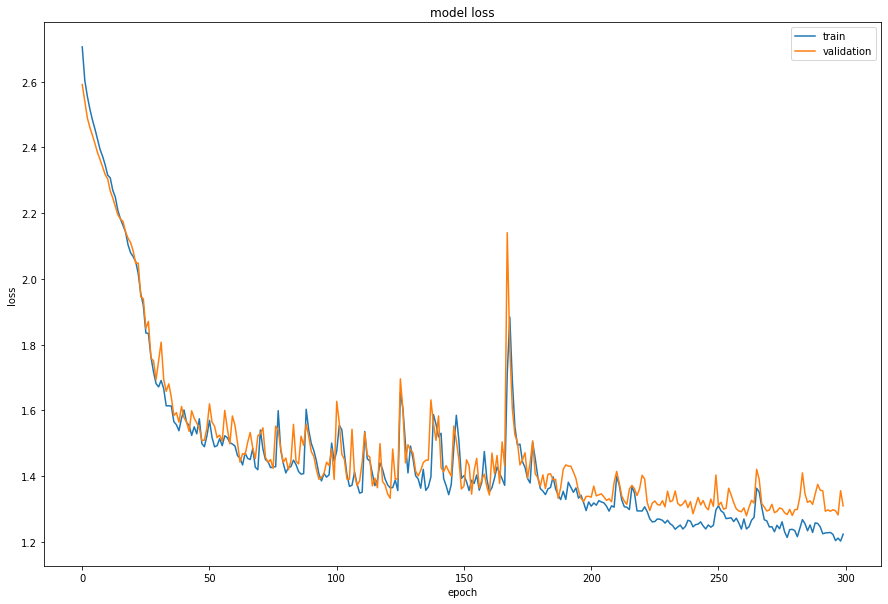

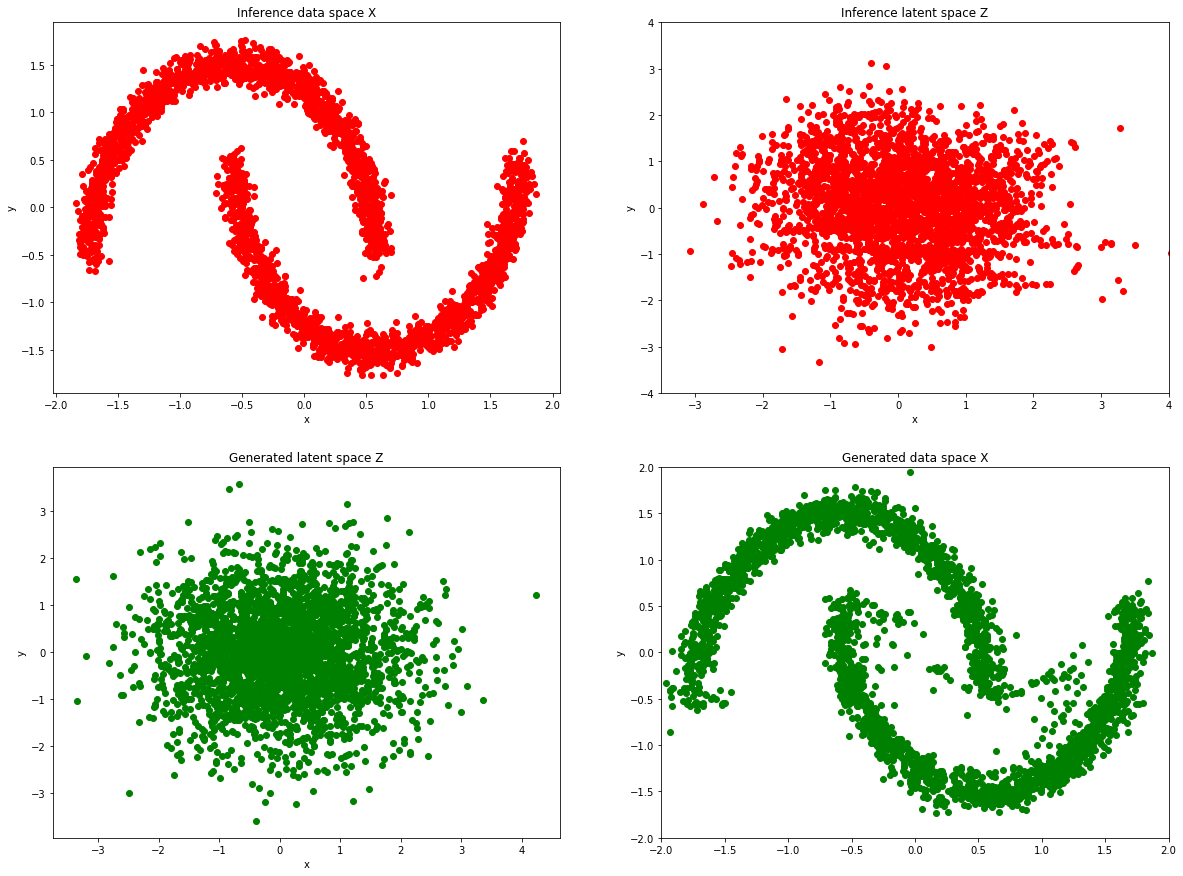

In [6]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])